# Random tests - AGEB and blocks 2020 data discrepancies.

The work on this Notebook found out a discrepancy between ageb population and block population in the database.
* Original method: Download agebs and blocks using aup.gdf_from_polygon with the area of interest (dissolved city's municipalities)
    * Problems: Disparities in __municipalities and pop data.__
 
* Method 2: Download agebs and blocks using CVE_ENTs and CVE_MUNs from city
    * Problems: Disparities in __agebs and pop data.__
* Method 3: Removing blocks that have AMBITO=='Rural', keeping AMBITO=='Urbana' only (For pop data comparison only, do not implement on Script)
    * Problems: A __problem on the source of pop data__ was identified.
 

__Implications for function calculate_censo_nan_values_v1 and Script 22__:
* Add new way to load pop data (CVEs tupples)
* In calculate_censo_nan_values_v1:
    * If an AGEB is present in mza_gdf, but not in ageb_gdf Step 2.4 (CALCULATE NaN values using AGEBs) could crash. Skip this AGEB.
    * If an AGEB is present in ageb_gdf, but not in mza_gdf it won't be a problem since we can loop over ageb in agebs present in mza_gdf.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Load Guadalajara's AGEB and block pop data (pop_ageb_gdf_0, pop_mza_gdf_0)

In [32]:
city = 'Guadalajara'
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
year = '2020'

# --------------- SCRIPT
# Load cities (municipalities)
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE (\"city\" = \'{city}\')"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
city_gdf = metro_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

print("Loading AGEBs for area of interest.")
pop_ageb_gdf_0 = aup.gdf_from_polygon(aoi,'censoageb',f'censoageb_{year}')
pop_ageb_gdf_0 = pop_ageb_gdf_0.set_crs("EPSG:4326")

print("Loading blocks for area of interest.")
pop_mza_gdf_0 = aup.gdf_from_polygon(aoi,'censo_mza',f'censo_mza_{year}')
pop_mza_gdf_0 = pop_mza_gdf_0.set_crs("EPSG:4326")

Loading AGEBs for area of interest.
Loading blocks for area of interest.


### Result: Disparities in municipalities.

In [35]:
print(city_gdf.CVE_MUN.unique())
print(pop_ageb_gdf_0.cve_mun.unique())
print(pop_mza_gdf_0.CVE_MUN.unique())

['039' '051' '070' '097' '098' '101' '120']
['039' '044' '051' '070' '097' '098' '101' '120' '124']
['039' '070' '097' '051' '101' '098' '120']


### Result: Disparities in population

In [36]:
# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf_0.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf_0.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf_0.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf_0.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 1600.
POBTOT en pop_ageb_gdf: 5000778.
AGEBs en pop_mza_gdf: 1600.
POBTOT en pop_mza_gdf: 5011955.


## Random test 1 - In order to solve the disparities in municipalities, is it necessary to download pop data using CVEs instead of gdf_from_polygon?

__Answer:__
* __Yes.__ Also, must use 'CVE_AGEB' col instead of 'ageb' when measuring available agebs. However, differences in population persist.

### Solución de query con tupple de municipios

In [38]:
# --------------- 1.1 CREATE AREA OF INTEREST FOR CITY
pop_ageb_gdf_1 = gpd.GeoDataFrame()
pop_mza_gdf_1 = gpd.GeoDataFrame()

# Load ents
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:

    #Load muns in each ent
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())

    # Load AGEBs and concat
    query = f"SELECT * FROM censoageb.censoageb_{year} WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {str(tuple(cve_mun_list))} "
    pop_ageb_gdf_1 = pd.concat([pop_ageb_gdf_1,aup.gdf_from_query(query, geometry_col='geometry')])

    # load Blocks and concat
    query = f"SELECT * FROM censo_mza.censo_mza_{year} WHERE (\"CVE_ENT\" = \'{cve_ent}\') AND \"CVE_MUN\" IN {str(tuple(cve_mun_list))} "
    pop_mza_gdf_1 = pd.concat([pop_mza_gdf_1,aup.gdf_from_query(query, geometry_col='geometry')])

### Result - SUCCESS - Disparities in municipalities solved.

In [39]:
print(city_gdf.CVE_MUN.unique())
print(pop_ageb_gdf_1.cve_mun.unique())
print(pop_mza_gdf_1.CVE_MUN.unique())

['039' '051' '070' '097' '098' '101' '120']
['039' '051' '070' '097' '098' '101' '120']
['070' '097' '101' '098' '120' '039' '051']


### Result - Disparities in number of AGEBs and in population

In [40]:
# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf_1.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf_1.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf_1.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf_1.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 1599.
POBTOT en pop_ageb_gdf: 4997967.
AGEBs en pop_mza_gdf: 1600.
POBTOT en pop_mza_gdf: 5011955.


## Random test 2 - Why is there a difference in AGEBs and pop data?
__Part 1__: Exploration of differences in AGEBs. We found two differences:
1. AGEB 1028, present in mza_gdf but missing from ageb_gdf. Both urban, __reason unknown.__
2. AGEB 1467, being both urban and rural.

__Conclusion of part 2.1: Removing rural blocks__ allows us to have a more accurate comparison of AGEB vs block data since AGEB data is only available for urban blocks.

__Part 2__: Removing rural blocks in order to have a more accurate comparison of AGEB vs block data.
__Conclusion of part 2.2:__ Even though we should only have urban data in both ageb and blocks data, __the difference in population persists.__ Even worst: it was revealed a major diff in pop data between agebs and blocks.

__Answer:__
* The source of data must be inspected.

### Part 2.1 - Exploration of differences in AGEBs

#### Identify differences in AGEBs (Extracted from an older version of function calculate_censo_nan_values_v1)

In [41]:
pop_ageb_gdf_2 = pop_ageb_gdf_1.copy()
pop_mza_gdf_2 = pop_mza_gdf_1.copy()

# --------------- 1.1 SET COLUMNS TO .UPPER() EXCEPT FOR GEOMETRY
# (When the equations were written, we used UPPER names, easier to change it this way and then return output with .lower columns)
pop_ageb_gdf_2.columns = pop_ageb_gdf_2.columns.str.upper()
pop_ageb_gdf_2.rename(columns={'GEOMETRY':'geometry'},inplace=True)

pop_mza_gdf_2.columns = pop_mza_gdf_2.columns.str.upper()
pop_mza_gdf_2.rename(columns={'GEOMETRY':'geometry'},inplace=True)

# --------------- 1.2 CHECK FOR DIFFERENCES IN AGEBs
# Look for AGEBs in both gdfs
agebs_in_ageb = list(pop_ageb_gdf_2['CVE_AGEB'].unique())
agebs_in_mza = list(pop_mza_gdf_2['CVE_AGEB'].unique())

if (len(agebs_in_ageb) == 0) and (len(agebs_in_mza) == 0):
    print("Error: Area of interest has no AGEB pop data.")
    intended_crash

# Test for AGEBs present in ageb_gdf but not in mza_gdf
missing_agebs_1 = list(set(agebs_in_ageb) - set(agebs_in_mza))
if len(missing_agebs_1) > 0:
    print(f'WARNING: AGEBs {missing_agebs_1} present in ageb_gdf but missing from mza_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_1} from analysis.')

# Test for AGEBs present in mza_gdf but not in AGEB_gdf
missing_agebs_2 = list(set(agebs_in_mza) - set(agebs_in_ageb))
if len(missing_agebs_2) > 0:
    print(f'WARNING: AGEBs {missing_agebs_2} present in mza_gdf but missing from ageb_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_2} from analysis.')

# List AGEBs in both dataframes (Remove duplicates using set)
agebs_analysis = agebs_in_ageb + agebs_in_mza
agebs_analysis = list(set(agebs_analysis))

# Remove missing AGEBs from agebs_analysis list
for ageb in missing_agebs_1 + missing_agebs_2:
    agebs_analysis.remove(ageb)

#### It was also noted that there are blocks classified as rural

In [44]:
pop_mza_gdf_2.loc[pop_mza_gdf_2.AMBITO == 'Rural'].CVE_AGEB.unique()

array(['1467'], dtype=object)

#### __Analysis cases: Case 1 AGEB 1028 and Case 2 AGEB 1467__

#### Case 1 AGEB 1028, present in mza_gdf but missing from ageb_gdf

In [50]:
case_1 = pop_mza_gdf_2.loc[pop_mza_gdf_2.CVE_AGEB == '1028'].copy()

print(case_1.POBTOT.sum())
print(case_1.AMBITO.unique())
case_1.head(1)

1642
['Urbana']


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
8680,1409700931028027,14,097,0093,1028,027,Urbana,Típica,"POLYGON ((-103.46954 20.57578, -103.46956 20.5...",14,...,None,None,None,None,None,None,None,None,None,None


<Axes: >

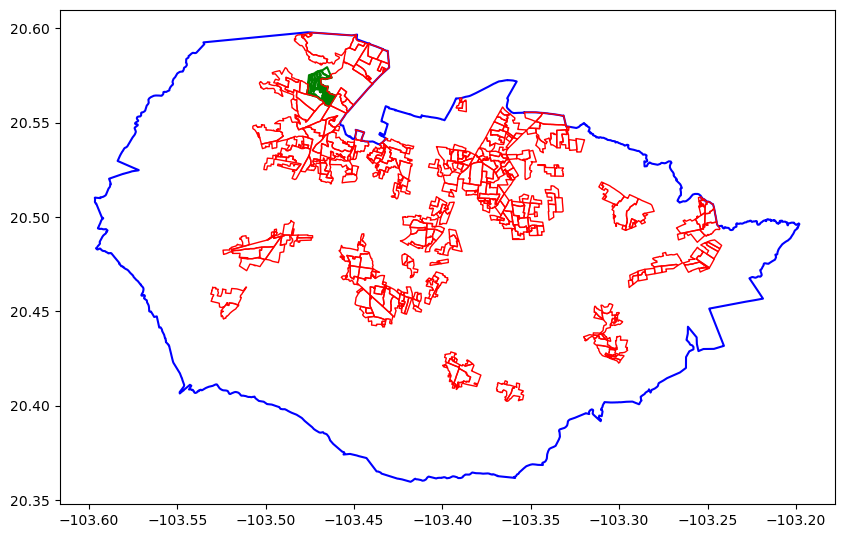

In [55]:
CVE_MUN = case_1.CVE_MUN.unique()[0]
# Locate municipality
case_1_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN].copy()
# Locate AGEBs of that municipality
case_1_mun_agebs = pop_ageb_gdf_2.loc[pop_ageb_gdf_2.CVE_MUN == CVE_MUN].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))
case_1_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_1.boundary.plot(ax=ax, color="green",zorder=2)
case_1_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

##### __The last image shows urban blocks that lack and AGEB. Why? Unknown.__

#### Case 2 AGEB 1467, appears as AMBITO == 'Rural' in pop_mza_gdf

In [57]:
case_2 = pop_mza_gdf_2.loc[pop_mza_gdf_2.CVE_AGEB == '1467'].copy()

print(case_2.POBTOT.sum())
print(case_2.AMBITO.unique())
case_2.head(1)

19353
['Rural' 'Urbana']


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
2956,1407001161467004,14,070,0116,1467,004,Rural,Típica,"POLYGON ((-103.18673 20.55292, -103.18671 20.5...",14,...,4,6,3,None,None,0,None,0,3,0


##### WHAT? Apparently that AGEB is both rural and urban.

In [58]:
case_2_urb = case_2.loc[case_2.AMBITO == 'Urbana'].copy()
case_2_rur = case_2.loc[case_2.AMBITO == 'Rural'].copy()

<Axes: >

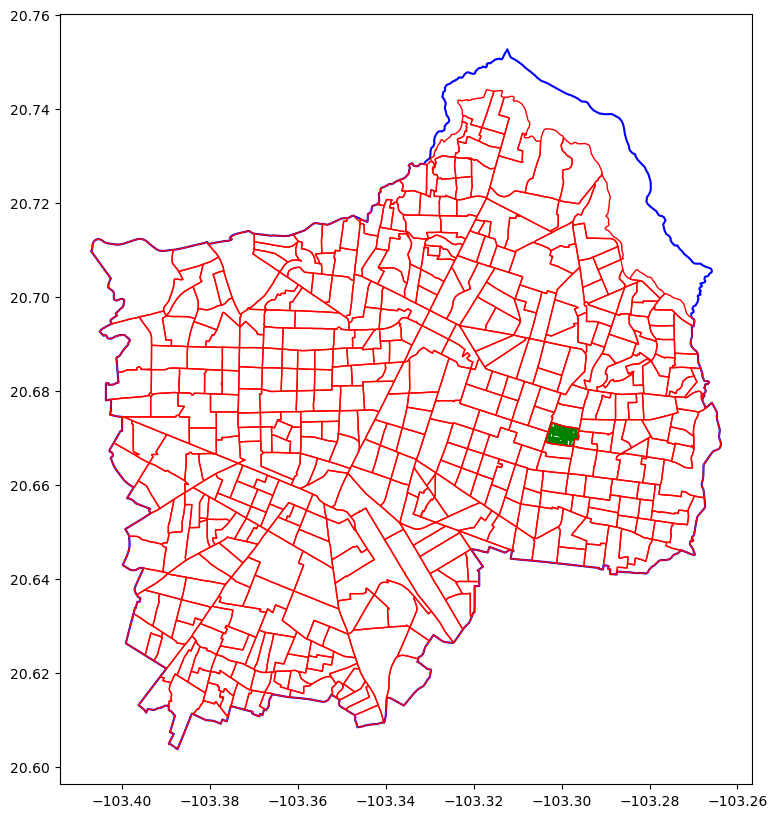

In [59]:
CVE_MUN_2 = case_2_urb.CVE_MUN.unique()[0]
# Locate municipality
case_2_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN_2].copy()
# Locate AGEBs of that municipality
case_2_mun_agebs = pop_ageb_gdf_2.loc[pop_ageb_gdf_2.CVE_MUN == CVE_MUN_2].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))
case_2_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_2_urb.boundary.plot(ax=ax, color="green",zorder=2)
case_2_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

<Axes: >

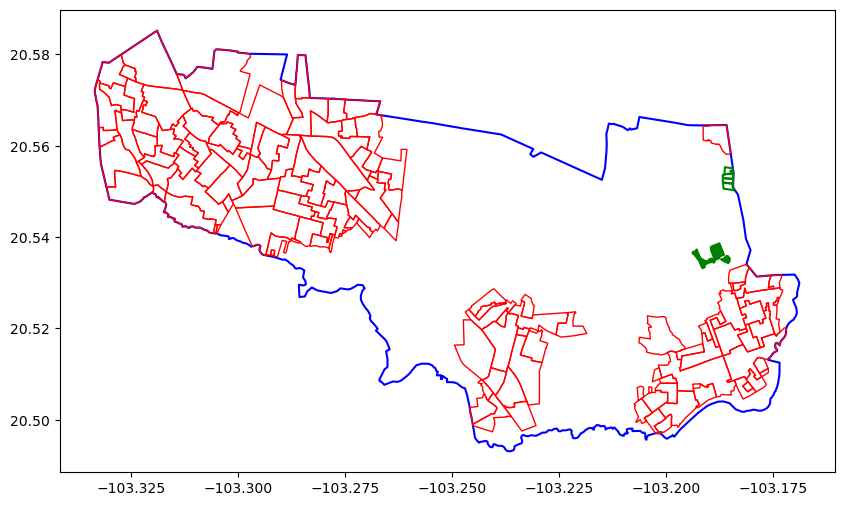

In [61]:
CVE_MUN_2 = case_2_rur.CVE_MUN.unique()[0]
# Locate municipality
case_2_mun = city_gdf.loc[city_gdf.CVE_MUN == CVE_MUN_2].copy()
# Locate AGEBs of that municipality
case_2_mun_agebs = pop_ageb_gdf_2.loc[pop_ageb_gdf_2.CVE_MUN == CVE_MUN_2].copy()

# Show
fig, ax = plt.subplots(figsize=(10, 10))
case_2_mun_agebs.plot(ax=ax, edgecolor="red",color='none',zorder=3)
case_2_rur.boundary.plot(ax=ax, color="green",zorder=2)
case_2_mun.boundary.plot(ax=ax, edgecolor="blue",zorder=1)

##### __The last two images show that we are talking about different areas. AGEB 1467 is an urban AGEB in a municipality, but also a rural AGEB (without AGEB boundary) in another municipality.__

In [62]:
print(f"Population of case 2: {case_2.POBTOT.sum()}.")
print(f"Population of the urban blocks in case 2: {case_2_urb.POBTOT.sum()}.")
print(f"Population of the corresponding urban ageb: {pop_ageb_gdf_2.loc[pop_ageb_gdf_2.CVE_AGEB == '1467'].POBTOT.sum()}.")
print(f"Population of the urban blocks in case 2 :{case_2_rur.POBTOT.sum()}.")

Population of case 2: 19353.
Population of the urban blocks in case 2: 4745.
Population of the corresponding urban ageb: 4745.
Population of the urban blocks in case 2 :14608.


##### __All the population of the urban ageb (4745) is within the urban blocks (4745). Therefore, the 'intruders' are the rural blocks.__

##### __Realization:__ If we want to have the same pop data in AGEBs gdf and in blocks gdf, we must remove AMBITO=='Rural' and keep only AMBITO=='Urbana' in the blocks when creating for the first time. Rural blocks do not have AGEB data.

### Part 2.2: Removing rural blocks in order to have a more accurate comparison of AGEB vs block data

In [63]:
pop_ageb_gdf_3 = gpd.GeoDataFrame()
pop_mza_gdf_3 = gpd.GeoDataFrame()

# Load ents
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:

    #Load muns in each ent
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())

    # Load AGEBs and concat
    query = f"SELECT * FROM censoageb.censoageb_{year} WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {str(tuple(cve_mun_list))} "
    pop_ageb_gdf_3 = pd.concat([pop_ageb_gdf_3,aup.gdf_from_query(query, geometry_col='geometry')])

    # load Blocks and concat
    query = f"SELECT * FROM censo_mza.censo_mza_{year} WHERE (\"CVE_ENT\" = \'{cve_ent}\') AND \"CVE_MUN\" IN {str(tuple(cve_mun_list))} "
    pop_mza_gdf_3 = pd.concat([pop_mza_gdf_3,aup.gdf_from_query(query, geometry_col='geometry')])
    if year == '2020':
        pop_mza_gdf_3 = pop_mza_gdf_3.loc[pop_mza_gdf_3.AMBITO == 'Urbana'].copy()

In [64]:
# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf_3.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf_3.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf_3.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf_3.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 1599.
POBTOT en pop_ageb_gdf: 4997967.
AGEBs en pop_mza_gdf: 1600.
POBTOT en pop_mza_gdf: 4997347.


##### __Now, WHY is there more population in pop_ageb_gdf (1599 agebs) than in pop_mza_gdf (1600 agebs)?__
##### Testing for pop in agebs and pop in blocks for each municipality.

In [73]:
for mun in list(pop_ageb_gdf_3.cve_mun.unique()):
    mun_ageb_gdf = pop_ageb_gdf_3.loc[pop_ageb_gdf_3.cve_mun == mun].copy()
    mun_mza_gdf = pop_mza_gdf_3.loc[pop_mza_gdf_3.CVE_MUN == mun].copy()

    pop_mun_ageb_gdf = mun_ageb_gdf.pobtot.sum()
    pop_mun_mza_gdf = mun_mza_gdf.POBTOT.sum()
    
    print(city_gdf.loc[city_gdf.CVE_MUN == mun].NOMGEO.unique()[0])
    print(f"Población en ageb_gdf: {pop_mun_ageb_gdf}.")
    print(f"Población en mza_gdf: {pop_mun_mza_gdf}.")
    print(f"__Diff: {pop_mun_ageb_gdf-pop_mun_mza_gdf}.__")
    print("--"*20)

Guadalajara
Población en ageb_gdf: 1385621.
Población en mza_gdf: 1385606.
__Diff: 15.__
----------------------------------------
Juanacatlán
Población en ageb_gdf: 26261.
Población en mza_gdf: 26200.
__Diff: 61.__
----------------------------------------
El Salto
Población en ageb_gdf: 211141.
Población en mza_gdf: 211022.
__Diff: 119.__
----------------------------------------
Tlajomulco de Zúñiga
Población en ageb_gdf: 686510.
Población en mza_gdf: 687751.
__Diff: -1241.__
----------------------------------------
San Pedro Tlaquepaque
Población en ageb_gdf: 678905.
Población en mza_gdf: 678372.
__Diff: 533.__
----------------------------------------
Tonalá
Población en ageb_gdf: 560074.
Población en mza_gdf: 559383.
__Diff: 691.__
----------------------------------------
Zapopan
Población en ageb_gdf: 1449455.
Población en mza_gdf: 1449013.
__Diff: 442.__
----------------------------------------


## Random test 3 - Examining previous problem, is it only a Guadalajara-problem?
__Answer:__
* Sadly, no.

In [75]:
city_test = 'Pachuca'
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
year = '2020'

# --------------- SCRIPT
# Load cities (municipalities)
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE (\"city\" = \'{city_test}\')"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
city_gdf = metro_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

pop_ageb_gdf_4 = gpd.GeoDataFrame()
pop_mza_gdf_4 = gpd.GeoDataFrame()

# Load ents
cve_ent_list = list(city_gdf.CVE_ENT.unique())
for cve_ent in cve_ent_list:

    #Load muns in each ent
    cve_mun_list = list(city_gdf.loc[city_gdf.CVE_ENT == cve_ent].CVE_MUN.unique())

    # Load AGEBs and concat
    query = f"SELECT * FROM censoageb.censoageb_{year} WHERE (\"cve_ent\" = \'{cve_ent}\') AND \"cve_mun\" IN {str(tuple(cve_mun_list))} "
    pop_ageb_gdf_4 = pd.concat([pop_ageb_gdf_4,aup.gdf_from_query(query, geometry_col='geometry')])

    # load Blocks and concat
    query = f"SELECT * FROM censo_mza.censo_mza_{year} WHERE (\"CVE_ENT\" = \'{cve_ent}\') AND \"CVE_MUN\" IN {str(tuple(cve_mun_list))} "
    pop_mza_gdf_4 = pd.concat([pop_mza_gdf_4,aup.gdf_from_query(query, geometry_col='geometry')])
    
    # FOR CURRENT TEST ONLY
    if year == '2020':
        pop_mza_gdf_4 = pop_mza_gdf_4.loc[pop_mza_gdf_4.AMBITO == 'Urbana'].copy()

# Show
print(f'AGEBs en pop_ageb_gdf: {len(pop_ageb_gdf_4.cve_ageb.unique())}.')
print(f'POBTOT en pop_ageb_gdf: {pop_ageb_gdf_4.pobtot.sum()}.')

print(f'AGEBs en pop_mza_gdf: {len(pop_mza_gdf_4.CVE_AGEB.unique())}.')
print(f'POBTOT en pop_mza_gdf: {pop_mza_gdf_4.POBTOT.sum()}.')

AGEBs en pop_ageb_gdf: 371.
POBTOT en pop_ageb_gdf: 511172.
AGEBs en pop_mza_gdf: 432.
POBTOT en pop_mza_gdf: 557836.


<Axes: >

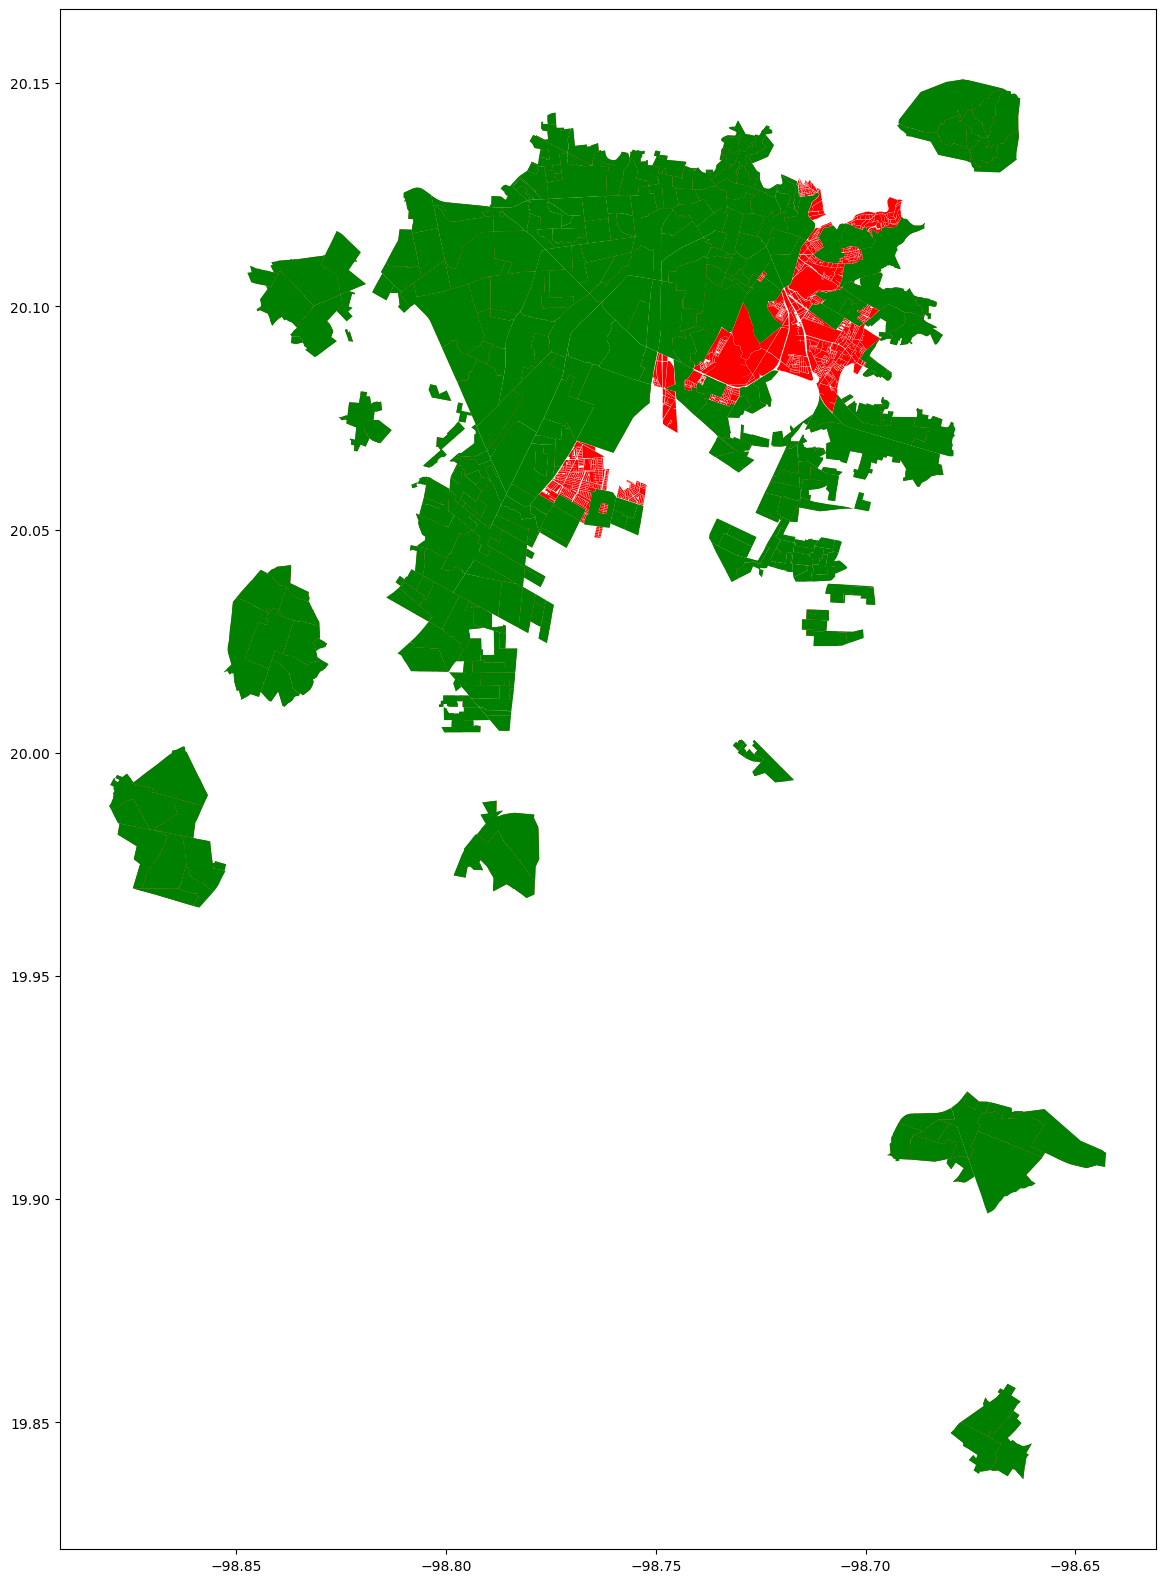

In [77]:
fig,ax = plt.subplots(figsize=(20,20))
pop_mza_gdf_4.plot(ax=ax,zorder=1,color='red')
pop_ageb_gdf_4.plot(ax=ax,color='green',zorder=2)